In [1]:
import re
import gzip
import math
import json
import pandas as pd
import numpy as np

from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
def readGz(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

In [3]:
data = []
for l in readGz("data/renttherunway_final_data.json.gz"):
    data.append(l)
    
df = pd.DataFrame(data)

In [4]:
df.head()

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
0,28,hourglass,34d,romper,fit,"5' 8""",2260466,10,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs
1,36,straight & narrow,34b,gown,fit,"5' 6""",153475,10,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs
2,116,NaN,NaN,sheath,fit,"5' 4""",1063761,10,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN
3,34,pear,34c,dress,fit,"5' 5""",126335,8,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs
4,27,athletic,34b,gown,fit,"5' 9""",616682,10,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs


In [5]:
def modify_height(row):
    height = row['height']
    if isinstance(height, float):
        return height
    lst = re.findall(r'\d+', height)
    return (int(lst[0]) * 12 + int(lst[1])) * 2.54

def modify_weight(row):
    weight = row['weight']
    if isinstance(weight, float):
        return weight
    return int(re.findall(r'\d+', weight)[0])

In [6]:
#Modify height and weight to numbers
modified_height = df.apply(modify_height, axis = 1)
modified_weight = df.apply(modify_weight, axis = 1)

df['height(cm)'] = modified_height
df['modified_weight'] = modified_weight

df = df.drop(['height', 'weight'], axis = 1)

In [7]:
df.head()

,age,body type,bust size,category,fit,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,height(cm),modified_weight
0,28,hourglass,34d,romper,fit,2260466,10,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,172.72,137.0
1,36,straight & narrow,34b,gown,fit,153475,10,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,167.64,132.0
2,116,NaN,NaN,sheath,fit,1063761,10,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,162.56,NaN
3,34,pear,34c,dress,fit,126335,8,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,165.10,135.0
4,27,athletic,34b,gown,fit,616682,10,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,175.26,145.0


In [8]:
df.dropna(subset=['age','body type','bust size','rating','rented for','height(cm)','modified_weight'],inplace = True)

In [9]:
df['age'] = df['age'].astype(float)
df['height(cm)'] = df['height(cm)'].astype(float)
df['size'] = df['size'].astype(float)
df['modified_weight'] = df['modified_weight'].astype(float)
df['rating'] = df['rating'].astype(float)

In [10]:
import torch
from string import punctuation

In [11]:
text_only = df[['review_text', 'fit']]
reviews = text_only['review_text'].values
labels = text_only['fit'].values

In [12]:
reviews = [review.lower() for review in reviews]

In [13]:
reviews[:10]

["an adorable romper! belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. wish it had pockets, but other than that-- absolutely perfect! i got a million compliments.",
 'i rented this dress for a photo shoot. the theme was "hollywood glam and big beautiful hats". the dress was very comfortable and easy to move around in. it is definitely on my list to rent again for another formal event. ',
 "i rented this for my company's black tie awards banquet.  i liked that this dress was short but was a little fancier with the sequins. (i generally don't care for long dresses.)  i would describe the color as more rose gold than yellow gold.  i have blonde hair and fair skin, and the color was very flattering.  this is a very forgiving dress! it's form fitting without making you feel like you're squeezed into it.  i would rent this one again.  highly recommend!",
 "i have always been petite in my upper body and extremely athletic. \ni'm 5'9

In [14]:
from string import punctuation

reviews_no_punc = []
for review in reviews:
    cur_review = ''.join([word for word in review if word not in punctuation])
    reviews_no_punc.append(cur_review)

In [15]:
reviews_split = [review.split() for review in reviews_no_punc]
reviews_split[:10]

[['an',
  'adorable',
  'romper',
  'belt',
  'and',
  'zipper',
  'were',
  'a',
  'little',
  'hard',
  'to',
  'navigate',
  'in',
  'a',
  'full',
  'day',
  'of',
  'wearbathroom',
  'use',
  'but',
  'thats',
  'to',
  'be',
  'expected',
  'wish',
  'it',
  'had',
  'pockets',
  'but',
  'other',
  'than',
  'that',
  'absolutely',
  'perfect',
  'i',
  'got',
  'a',
  'million',
  'compliments'],
 ['i',
  'rented',
  'this',
  'dress',
  'for',
  'a',
  'photo',
  'shoot',
  'the',
  'theme',
  'was',
  'hollywood',
  'glam',
  'and',
  'big',
  'beautiful',
  'hats',
  'the',
  'dress',
  'was',
  'very',
  'comfortable',
  'and',
  'easy',
  'to',
  'move',
  'around',
  'in',
  'it',
  'is',
  'definitely',
  'on',
  'my',
  'list',
  'to',
  'rent',
  'again',
  'for',
  'another',
  'formal',
  'event'],
 ['i',
  'rented',
  'this',
  'for',
  'my',
  'companys',
  'black',
  'tie',
  'awards',
  'banquet',
  'i',
  'liked',
  'that',
  'this',
  'dress',
  'was',
  'short

In [16]:
import itertools
from collections import Counter

all_words = list(itertools.chain(*reviews_split))

count_words = Counter(all_words)
total_words = len(all_words)
sorted_words = count_words.most_common()
sorted_words[:10]

[('the', 498858),
 ('i', 379743),
 ('a', 318368),
 ('and', 289663),
 ('it', 270307),
 ('was', 225301),
 ('dress', 195923),
 ('to', 178681),
 ('this', 152039),
 ('but', 117042)]

In [17]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] for w in review]
    reviews_int.append(r)
print(reviews_int[:3])

[[66, 824, 586, 413, 4, 193, 86, 3, 31, 334, 8, 5000, 12, 3, 404, 167, 14, 19662, 420, 10, 449, 8, 38, 341, 207, 5, 37, 196, 10, 124, 69, 21, 173, 33, 2, 51, 3, 711, 39], [2, 109, 9, 7, 11, 3, 405, 1501, 1, 1210, 6, 1420, 1410, 4, 112, 71, 7188, 1, 7, 6, 24, 34, 4, 180, 8, 382, 122, 12, 5, 13, 52, 18, 15, 2481, 8, 72, 64, 11, 285, 211, 119], [2, 109, 9, 11, 15, 2442, 116, 295, 1443, 2268, 2, 210, 21, 9, 7, 6, 82, 10, 6, 3, 31, 2498, 17, 1, 250, 2, 998, 183, 1158, 11, 54, 142, 2, 23, 2203, 1, 63, 36, 65, 1059, 271, 69, 1233, 271, 2, 22, 3064, 616, 4, 1676, 442, 4, 1, 63, 6, 24, 78, 9, 13, 3, 24, 378, 7, 58, 368, 265, 148, 620, 32, 152, 44, 244, 1947, 292, 5, 2, 23, 72, 9, 81, 64, 233, 88]]


In [18]:
encoded_labels = [0 if lab == 'fit' else 1 if lab == 'small' else 2 for lab in labels ]
encoded_labels = np.array(encoded_labels)
encoded_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2])

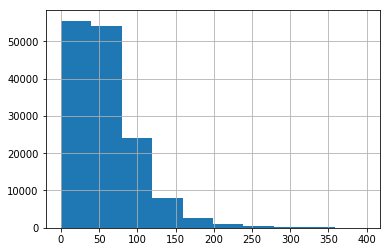

count    146381.000000
mean         59.352751
std          43.390558
min           0.000000
25%          28.000000
50%          51.000000
75%          80.000000
max         398.000000
dtype: float64

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [20]:
reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

In [21]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [22]:
features = pad_features(reviews_int, 150)
features[:100]

array([[    0,     0,     0, ...,     3,   711,    39],
       [    0,     0,     0, ...,   285,   211,   119],
       [    0,     0,     0, ...,    64,   233,    88],
       ...,
       [    0,     0,     0, ...,     4,   117,    30],
       [    0,     0,     0, ...,    13,    66, 19677],
       [    0,     0,     0, ...,    49,    93,  1158]])

In [23]:
X = features
y = np.array(encoded_labels)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.2)

In [33]:
print(len(X_train))
print(len(y_test))
print(len(y_valid))

117025
23405
5852


In [69]:
len(vocab_to_int)

43440

In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [35]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 150])
Sample input: 
 tensor([[   0,    0,    0,  ...,    4, 8519, 1795],
        [   0,    0,    0,  ...,  152,   65,   71],
        [   0,    0,    0,  ...,    1,  937,  160],
        ...,
        [   0,    0,    0,  ...,    3,  111,    7],
        [   0,    0,    0,  ...,    5,    6,   33],
        [   2,  120,  213,  ...,    1,  142,   59]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 2,
        0, 0])


In [61]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

In [62]:
def train_func(train_loader):

    # Train the model
    train_loss = 0
    train_acc = 0
    
    for i, (text, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        text, labels = text.to(device), labels.to(device)
        output = model(text)
        loss = criterion(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == labels).sum().item() / labels.size()[0]

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(train_loader), train_acc / len(train_loader)

def test(data):
    losses = []
    loss = 0
    acc = 0
    
    for text, labels in data:
        text, labels = text.to(device), labels.to(device)
        with torch.no_grad():
            output = model(text)
            loss = criterion(output, labels)
            losses.append(loss.item())
            acc += (output.argmax(1) == labels).sum().item() / labels.size()[0]

    return np.average(losses), acc/len(data)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VOCAB_SIZE = len(vocab_to_int) + 1
EMBED_DIM = 256
NUM_CLASS = 3
BATCH_SIZE = 50

model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)
model

TextSentiment(
  (embedding): EmbeddingBag(43441, 256, mode=mean)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [64]:
import time
import copy
N_EPOCHS = 50
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

valid_losses = []
count_increase = 0
train_losses = []
train_accu = []
valid_accu = []
models = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    models.append(copy.deepcopy(model))
    valid_loss, valid_acc = test(valid_loader)
    train_losses.append(train_loss)
    train_accu.append(train_acc)
    valid_accu.append(valid_acc)
    
    
    if not valid_losses:
        valid_losses.append(valid_loss)
    elif valid_loss > valid_losses[-1] :
        valid_losses.append(valid_loss)
        count_increase += 1
    else:
        valid_losses.append(valid_loss)
        count_increase = 0

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    
    if count_increase == 2:
        print('Early stopping')
        break

Epoch: 1  | time in 0 minutes, 23 seconds
	Loss: 0.7966(train)	|	Acc: 72.4%(train)
	Loss: 0.7817(valid)	|	Acc: 72.4%(valid)
Epoch: 2  | time in 0 minutes, 22 seconds
	Loss: 0.7881(train)	|	Acc: 72.7%(train)
	Loss: 0.7757(valid)	|	Acc: 73.0%(valid)
Epoch: 3  | time in 0 minutes, 22 seconds
	Loss: 0.7861(train)	|	Acc: 72.8%(train)
	Loss: 0.7778(valid)	|	Acc: 73.2%(valid)
Epoch: 4  | time in 0 minutes, 22 seconds
	Loss: 0.7852(train)	|	Acc: 72.9%(train)
	Loss: 0.7752(valid)	|	Acc: 73.2%(valid)
Epoch: 5  | time in 0 minutes, 22 seconds
	Loss: 0.7844(train)	|	Acc: 73.0%(train)
	Loss: 0.7728(valid)	|	Acc: 73.3%(valid)
Epoch: 6  | time in 0 minutes, 22 seconds
	Loss: 0.7839(train)	|	Acc: 73.0%(train)
	Loss: 0.7730(valid)	|	Acc: 73.4%(valid)
Epoch: 7  | time in 0 minutes, 21 seconds
	Loss: 0.7834(train)	|	Acc: 73.1%(train)
	Loss: 0.7722(valid)	|	Acc: 73.5%(valid)
Epoch: 8  | time in 0 minutes, 24 seconds
	Loss: 0.7830(train)	|	Acc: 73.1%(train)
	Loss: 0.7791(valid)	|	Acc: 73.2%(valid)
Epoch: 9

In [65]:
def test_with_model(data, model):
    losses = []
    loss = 0
    acc = 0
    
    for text, labels in data:
        text, labels = text.to(device), labels.to(device)
        with torch.no_grad():
            output = model(text)
            loss = criterion(output, labels)
            losses.append(loss.item())
            acc += (output.argmax(1) == labels).sum().item() / labels.size()[0]

    return np.average(losses), acc/len(data)

In [66]:
test_loss, test_acc = test_with_model(test_loader, models[-3])
print(test_acc)

0.7310874200426438


In [49]:
from sklearn.metrics import balanced_accuracy_score

In [55]:
def balanced_accu(data, model):
    losses = []
    loss = 0
    balanced_acc = 0
    
    for text, labels in data:
        text, labels = text.to(device), labels.to(device)
        with torch.no_grad():
            predictions = model(text)
            predictions = np.array(predictions).argmax(1)
            balanced_acc += balanced_accuracy_score(predictions, labels.tolist())
    return balanced_acc/len(data)

In [56]:
bal_acc = balanced_accu(test_loader, models[-3])

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [57]:
bal_acc

0.681654878354131

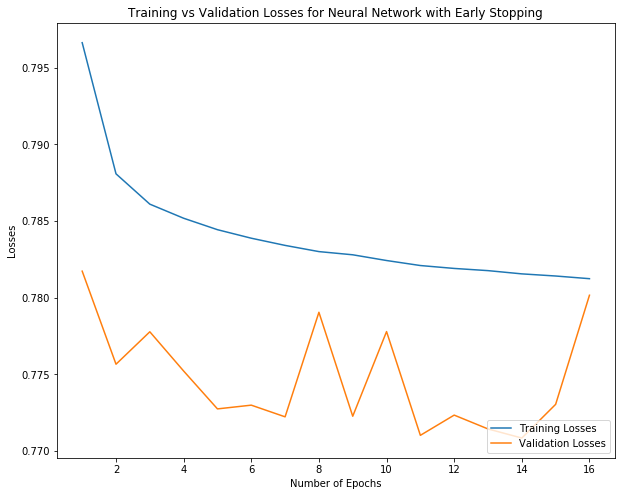

In [67]:
graph_title = 'Training vs Validation Losses for Neural Network with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('baseline_train_vad_loss.png')

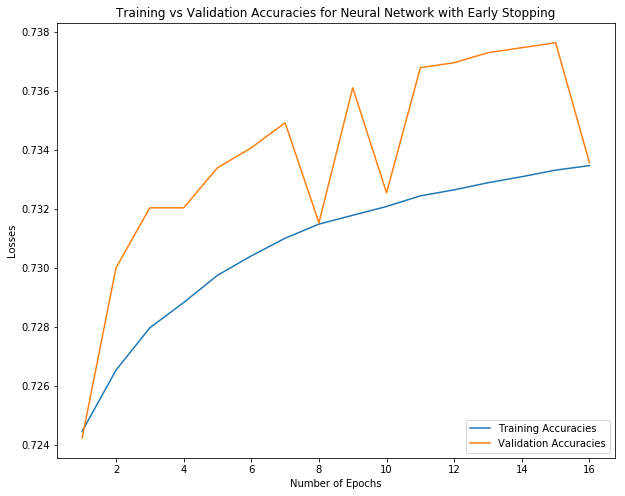

In [68]:
graph_title = 'Training vs Validation Accuracies for Neural Network with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_accu) + 1), train_accu, label='Training Accuracies')
ax.plot(np.arange(1, len(valid_accu) + 1), valid_accu, label='Validation Accuracies')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('baseline_train_accu_loss.png')